### Информация
- *Автор*: Зитцер Данил
- *Дата*: вторник, 8 октября 2021 г., 08:32:49
- *Описание*: Введение в свёрточные нейронные сети

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.rcParams['figure.figsize'] = (18, 9)
plt.rcParams['font.size'] = 20

### Полносвязные нейронные сети

![](https://www.researchgate.net/profile/Charlotte_Pelletier/publication/331525817/figure/fig2/AS:733072932745216@1551789615161/Example-of-fully-connected-neural-network.png)

### Генерация набора данных

In [2]:
import cv2

In [3]:
def random_figure_generator():
    ''' Возвращает изображение 100 на 100, чередуя квадраты и круги '''
    is_rectangle = False
    
    while True:       
        # прямоугольник --> круг --> прямоугольник --> круг --> ....
        is_rectangle = not is_rectangle
        
        image = np.zeros(shape=(100, 100), dtype=np.uint8)
        size = np.random.randint(low=5, high=45, dtype=np.uint8)

        if is_rectangle:
            x1, y1 = 50 - size, 50 - size
            x2, y2 = 50 + size, 50 + size
            
            image = cv2.rectangle(image, (x1, y1), (x2, y2), (255, 255, 255), 1)
        else:
            image = cv2.circle(image, (50, 50), size, (255, 255, 255), 1)

        yield image, is_rectangle

In [4]:
figure_gen = random_figure_generator()

Text(0.5, 1.0, 'True')

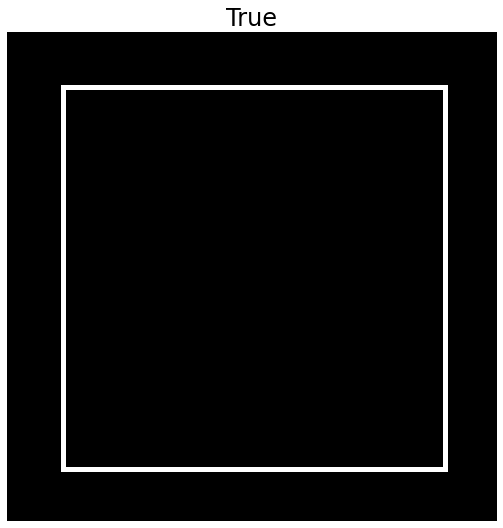

In [5]:
image, label = next(figure_gen)

plt.imshow(image, cmap='gray')
plt.axis('off')
plt.title(label)

Обернём наш генератор в tf.data.Dataset

[tf.data.Dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset)

Конвеер трансформации исходных данных во входные данные нейронной сети

![](./../images/01-tf-data.png)

In [6]:
import tensorflow as tf

2021-10-08 09:33:48.047050: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-10-08 09:33:48.047064: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [7]:
ds = tf.data.Dataset.from_generator(
    generator=random_figure_generator,
    output_signature=(
        tf.TensorSpec(shape=(100, 100), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.int32),
    )
)

2021-10-08 09:33:48.731741: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-10-08 09:33:48.731758: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-10-08 09:33:48.731770: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (swift): /proc/driver/nvidia/version does not exist
2021-10-08 09:33:48.731972: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


2021-10-08 09:33:48.762642: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


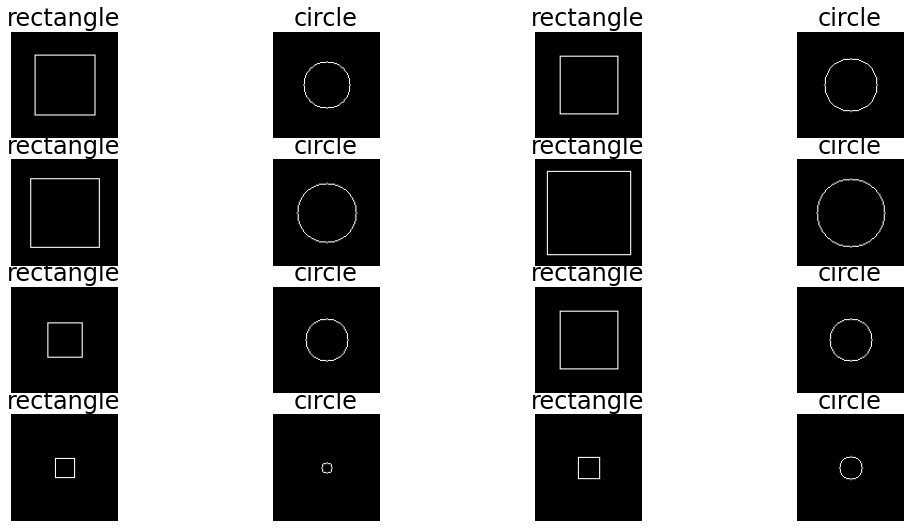

In [8]:
ds_iter = iter(ds)

label_mapping = {0: 'circle', 1: 'rectangle'}

fig, axes = plt.subplots(4, 4)

for ax in axes.flat:
    image, label = next(ds_iter)
    ax.imshow(image, cmap='gray')
    ax.set_title(label_mapping[label.numpy()])
    ax.axis('off')

#### Архитектура модели

С лосс-функциями всё просто: она подбирается в зависимости от функции активации на последнем слое.

![](https://miro.medium.com/max/1858/1*IhP8BdoUpAbssltq0VBafg.png)

**ВНИМАНИЕ!**

In [9]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import metrics
from tensorflow.keras import models
from tensorflow.keras import optimizers

In [10]:
loss_mapping = {
    'sigmoid': 'binary_crossentropy',
    'softmax': 'categorical_crossentropy',
}

def build_model(units: int, activation: str):
    model = models.Sequential()

    model.add(layers.InputLayer(input_shape=(100, 100), name='input_layer'))
    model.add(layers.experimental.preprocessing.Rescaling(scale=1./255, name='rescaling_layer'))
    model.add(layers.Flatten(name='flatten_layer'))
    model.add(layers.Dense(units=units, activation=activation, name='dense_layer'))

    model.compile(
        optimizer='sgd',
        loss=loss_mapping[activation],
        metrics=[
            metrics.Precision(name='precision'),
            metrics.Recall(name='recall'),
        ]
    )

    return model

**СКОЛЬКО БУДЕТ ПАРАМЕТРОВ У МОДЕЛЕЙ С 1 ИЛИ 2 НЕЙРОНАМИ?**

#### Модель, предсказывающая вероятность прямоугольника (бинарная классификация)

Модель: один нейрон и функция активации сигмоида.

Возвращает вероятность нахождения на изображении квадрата.

In [11]:
model = build_model(units=1, activation='sigmoid')

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_layer (Rescaling)  (None, 100, 100)          0         
_________________________________________________________________
flatten_layer (Flatten)      (None, 10000)             0         
_________________________________________________________________
dense_layer (Dense)          (None, 1)                 10001     
Total params: 10,001
Trainable params: 10,001
Non-trainable params: 0
_________________________________________________________________


In [12]:
model.fit(
    x=ds.batch(32).prefetch(1),
    epochs=4,
    steps_per_epoch=1024,
    validation_data=ds.batch(128).prefetch(1),
    validation_steps=16,
)

Epoch 1/4
1024/1024 [==============================] - 4s 4ms/step - loss: 0.5112 - precision: 0.8756 - recall: 0.8684 - val_loss: 0.4002 - val_precision: 0.9700 - val_recall: 0.9805
Epoch 2/4
1024/1024 [==============================] - 4s 4ms/step - loss: 0.3427 - precision: 0.9920 - recall: 0.9858 - val_loss: 0.2922 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 3/4
1024/1024 [==============================] - 4s 4ms/step - loss: 0.2620 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.2334 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 4/4
1024/1024 [==============================] - 4s 4ms/step - loss: 0.2120 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.1898 - val_precision: 1.0000 - val_recall: 1.0000


In [13]:
weights, bias = model.get_layer('dense_layer').get_weights()

print(len(weights))
print(len(bias))

10000
1


**ВНИМАНИЕ!**

(-0.5, 99.5, 99.5, -0.5)

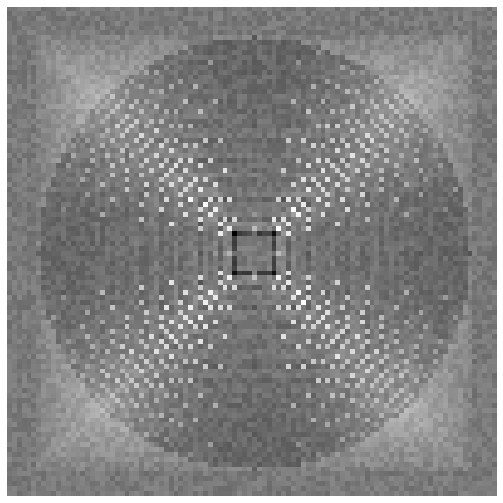

In [14]:
plt.imshow(weights.reshape(100, 100), cmap='gray')
plt.axis('off')

**ИНТЕРПРЕТИРУЙТЕ РЕЗУЛЬТАТ?**

#### Модель, предсказывающая вероятности и для прямоугольника, и для круга (пересекающиеся классы)

Модель: два нейрона и функция активации сигмоида.

Возвращает отдельно вероятности нахождения на изображении квадрата и круга.

**ВНИМАНИЕ!**

In [15]:
model = build_model(units=2, activation='sigmoid')

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_layer (Rescaling)  (None, 100, 100)          0         
_________________________________________________________________
flatten_layer (Flatten)      (None, 10000)             0         
_________________________________________________________________
dense_layer (Dense)          (None, 2)                 20002     
Total params: 20,002
Trainable params: 20,002
Non-trainable params: 0
_________________________________________________________________


**ЧТО НЕ ТАК НА ТЕКУЩИЙ МОМЕНТ С ВХОДНЫМИ ДАННЫМИ?**

In [16]:
image, label = next(iter(ds))

print(image.shape)
print(label.shape)

(100, 100)
()


In [17]:
label

<tf.Tensor: shape=(), dtype=int32, numpy=1>

![](https://miro.medium.com/max/2474/1*ggtP4a5YaRx6l09KQaYOnw.png)

In [18]:
tf.equal(tf.range(2), label)

<tf.Tensor: shape=(2,), dtype=bool, numpy=array([False,  True])>

In [19]:
ds = ds.map(lambda x, y: (x, tf.cast(tf.equal(tf.range(2), y), dtype=tf.float32)))

In [20]:
model.fit(
    x=ds.batch(32).prefetch(1),
    epochs=4,
    steps_per_epoch=1024,
    validation_data=ds.batch(128).prefetch(1),
    validation_steps=16,
)

Epoch 1/4
1024/1024 [==============================] - 5s 5ms/step - loss: 0.5743 - precision: 0.8156 - recall: 0.8217 - val_loss: 0.4929 - val_precision: 0.9710 - val_recall: 0.9814
Epoch 2/4
1024/1024 [==============================] - 5s 5ms/step - loss: 0.4434 - precision: 0.9757 - recall: 0.9774 - val_loss: 0.3940 - val_precision: 0.9873 - val_recall: 0.9873
Epoch 3/4
1024/1024 [==============================] - 5s 5ms/step - loss: 0.3656 - precision: 0.9941 - recall: 0.9958 - val_loss: 0.3442 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 4/4
1024/1024 [==============================] - 5s 5ms/step - loss: 0.3178 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.2975 - val_precision: 1.0000 - val_recall: 1.0000


**ВНИМАНИЕ!**

In [21]:
weights, bias = model.get_layer('dense_layer').get_weights()

print(len(weights))
print(len(bias))

10000
2


**ПОЧЕМУ СМЕЩЕНИЙ 2, А ВЕСОВ ВСЁ ТАК ЖЕ 10000?**

In [22]:
len([[1, 2], [3, 4], [5, 6]])

3

In [23]:
weights.shape

(10000, 2)

Text(0.5, 1.0, 'Rectangle weights\n')

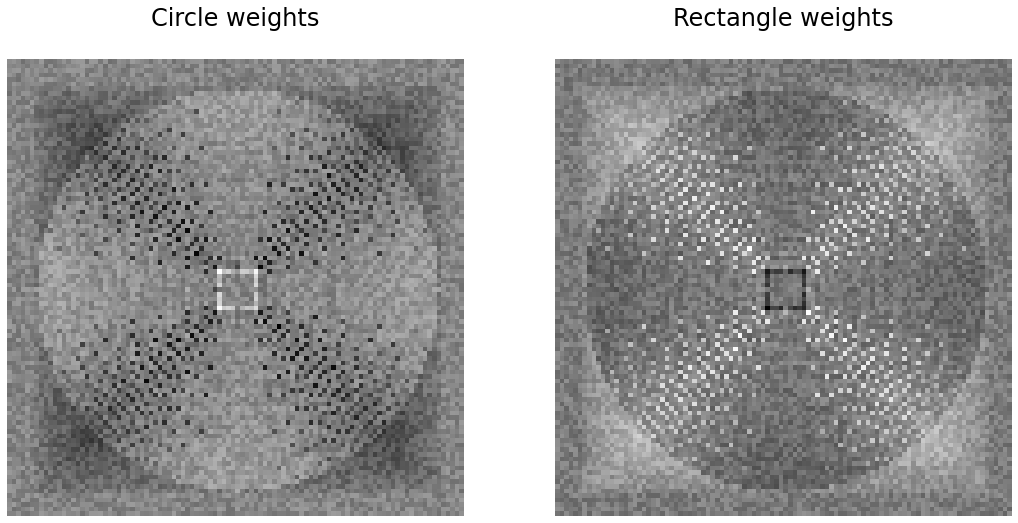

In [24]:
fig, axes = plt.subplots(1, 2)

axes[0].imshow(weights[:, 0].reshape(100, 100), cmap='gray')
axes[0].axis('off')
axes[0].set_title('Circle weights\n')

axes[1].imshow(weights[:, 1].reshape(100, 100), cmap='gray')
axes[1].axis('off')
axes[1].set_title('Rectangle weights\n')

**ВНИМАНИЕ!**

In [25]:
predictions = model.predict(ds.map(lambda x, y: x).batch(16).take(1))
predictions

array([[0.26479524, 0.7344234 ],
       [0.76474106, 0.23574576],
       [0.14626789, 0.8536686 ],
       [0.764018  , 0.23657104],
       [0.13914064, 0.86084366],
       [0.55353516, 0.44596687],
       [0.20188841, 0.7977383 ],
       [0.69001204, 0.31145132],
       [0.30554047, 0.6930462 ],
       [0.80456364, 0.1956746 ],
       [0.33889934, 0.66664255],
       [0.7606074 , 0.23991135],
       [0.07607663, 0.92401254],
       [0.8305558 , 0.16953814],
       [0.24149579, 0.75768393],
       [0.7606074 , 0.23991135]], dtype=float32)

**ЧТО НЕ ТАК С ЭТИМИ ПРЕДСКАЗАНИЯМИ?**

In [26]:
predictions.sum(1)

array([0.99921864, 1.0004869 , 0.99993646, 1.000589  , 0.99998426,
       0.99950206, 0.99962676, 1.0014634 , 0.99858665, 1.0002382 ,
       1.0055419 , 1.0005188 , 1.0000892 , 1.0000939 , 0.9991797 ,
       1.0005188 ], dtype=float32)

In [27]:
predictions.sum(1) == 1.0

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False])

#### Модель, предсказывающая вероятности и для прямоугольника, и для круга (многоклассовая классификация)

Модель: два нейрона и функция активации софтмакс.

Возвращает взаимоисключающие вероятности квадрата и круга.

In [28]:
model = build_model(units=2, activation='softmax')

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_layer (Rescaling)  (None, 100, 100)          0         
_________________________________________________________________
flatten_layer (Flatten)      (None, 10000)             0         
_________________________________________________________________
dense_layer (Dense)          (None, 2)                 20002     
Total params: 20,002
Trainable params: 20,002
Non-trainable params: 0
_________________________________________________________________


In [29]:
model.fit(
    x=ds.batch(32).prefetch(1),
    epochs=4,
    steps_per_epoch=1024,
    validation_data=ds.batch(128).prefetch(1),
    validation_steps=16,
)

Epoch 1/4
1024/1024 [==============================] - 5s 5ms/step - loss: 0.4314 - precision: 0.9186 - recall: 0.9186 - val_loss: 0.3023 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 2/4
1024/1024 [==============================] - 5s 5ms/step - loss: 0.2399 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.1939 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 3/4
1024/1024 [==============================] - 5s 5ms/step - loss: 0.1663 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.1435 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 4/4
1024/1024 [==============================] - 5s 5ms/step - loss: 0.1271 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.1142 - val_precision: 1.0000 - val_recall: 1.0000


In [30]:
weights, bias = model.get_layer('dense_layer').get_weights()

print(weights.shape)
print(bias.shape)

(10000, 2)
(2,)


Text(0.5, 1.0, 'Rectangle weights\n')

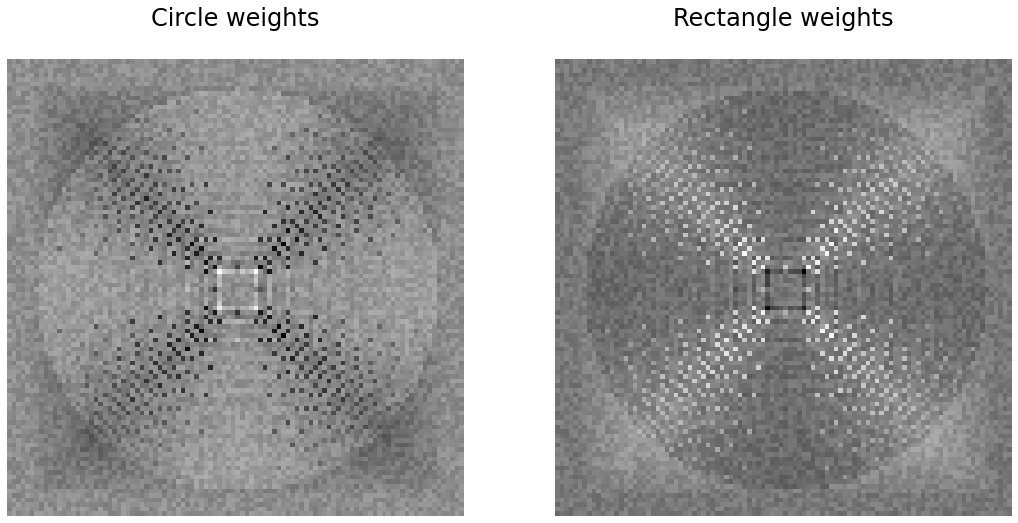

In [31]:
fig, axes = plt.subplots(1, 2)

axes[0].imshow(weights[:, 0].reshape(100, 100), cmap='gray')
axes[0].axis('off')
axes[0].set_title('Circle weights\n')

axes[1].imshow(weights[:, 1].reshape(100, 100), cmap='gray')
axes[1].axis('off') 
axes[1].set_title('Rectangle weights\n')

In [32]:
predictions = model.predict(ds.batch(32).take(1))
predictions

array([[0.22826114, 0.7717388 ],
       [0.9472253 , 0.05277478],
       [0.09054445, 0.90945554],
       [0.7666964 , 0.23330359],
       [0.00877516, 0.9912248 ],
       [0.9632574 , 0.03674261],
       [0.20580402, 0.794196  ],
       [0.8949373 , 0.10506274],
       [0.19318053, 0.80681944],
       [0.75104195, 0.24895807],
       [0.05261647, 0.94738346],
       [0.9711573 , 0.02884274],
       [0.06978054, 0.9302194 ],
       [0.8949373 , 0.10506274],
       [0.1027083 , 0.8972917 ],
       [0.97622776, 0.02377229],
       [0.14045541, 0.85954463],
       [0.8393829 , 0.16061716],
       [0.1413254 , 0.85867465],
       [0.8949373 , 0.10506274],
       [0.00423671, 0.9957633 ],
       [0.8559834 , 0.14401665],
       [0.1413254 , 0.85867465],
       [0.7593268 , 0.2406732 ],
       [0.1413254 , 0.85867465],
       [0.7679868 , 0.23201324],
       [0.03755531, 0.96244466],
       [0.93956864, 0.0604313 ],
       [0.02351901, 0.97648096],
       [0.75104195, 0.24895807],
       [0.

In [33]:
predictions.sum(1)

array([1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       0.99999994, 1.        , 0.99999994, 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 0.99999994, 1.        , 1.        ,
       1.        , 1.        ], dtype=float32)

#### Недостатки полносвязных нейронных сетей

cons:
- [полносвязные сети неинвариантны относительно сдвигов](https://www.cs.ryerson.ca/~aharley/vis/conv/flat.html)
- зависимость количества параметров от размера входа

pros:
- [работа со структурированными данными](https://playground.tensorflow.org)



## Свёрточные нейронные сети

### Типы задач компьютерного зрения:

![](https://www.oreilly.com/content/wp-content/uploads/sites/2/2019/06/Figure1-3bb53c4be7b5b4c134ddd7a61dbe776a.jpg)

### Операция свёртки

![](http://go.dialektika.com/images/mlearning/14_01.jpg)

![](http://go.dialektika.com/images/mlearning/14_02.jpg)

![](https://overcoder.net/img/1/26/37/253600.gif)

![](https://upload.wikimedia.org/wikipedia/commons/1/19/2D_Convolution_Animation.gif)

![](https://i.stack.imgur.com/FjvuN.gif)

Пример операции свёртки

(-0.5, 416.5, 416.5, -0.5)

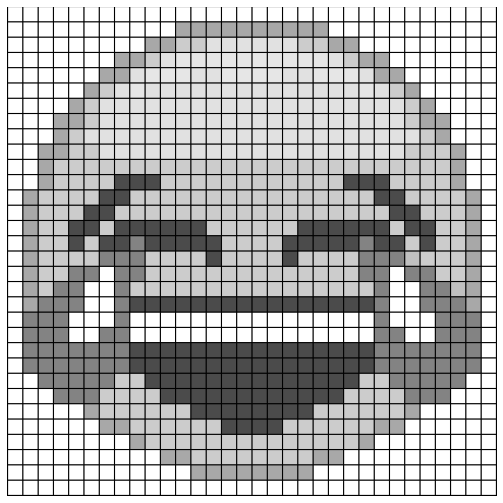

In [34]:
image = tf.io.decode_png(tf.io.read_file('./../images/02-smile.png'))
image = tf.image.rgb_to_grayscale(image)

plt.imshow(image, cmap='gray')
plt.axis('off')

Прогоним изображение смайла через фильтры:
- вертикальной линии
- горизонтальной линии
- фильтр размытия

In [35]:
# добавим размерность к нашему изображению
input_ = tf.expand_dims(tf.cast(image, tf.float32), 0)
# 3 фильтра с 1 каналом размером 7 столбцов на 7 строк (интерпретация shape справа налево)
filters = np.zeros(shape=(7, 7, 1, 3), dtype=np.float32)

filters[:, 3, :, 0]  = 1  # фильтр вертикальной линии
filters[3, :, :, 1]  = 1  # фильтр горизонтальной линии
filters[:, :, :, 2]  = 1/49  # фильтр размытия
# применями фильтры к входному изображению
outputs = tf.nn.conv2d(input_, filters, strides=1, padding='SAME')
outputs.shape

TensorShape([1, 417, 417, 3])

Визуализируем изображения после прогонки фильтров:

Text(0.5, 1.0, 'blurred')

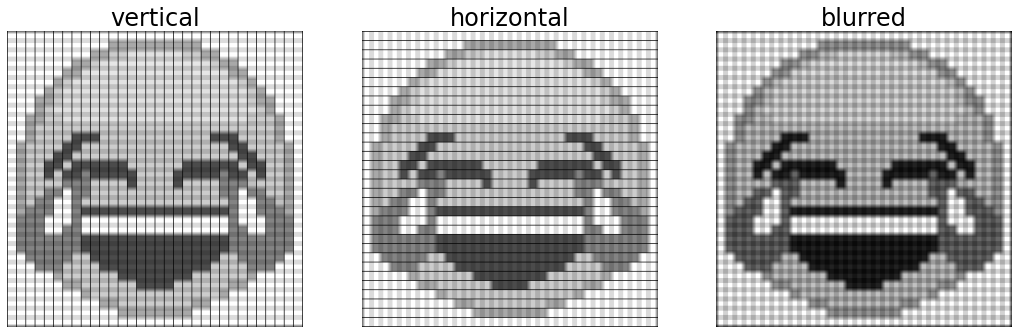

In [36]:
fig, ax = plt.subplots(1, 3)

ax[0].imshow(outputs[0, :, :, 0], cmap='gray')
ax[0].axis('off')
ax[0].set_title('vertical')

ax[1].imshow(outputs[0, :, :, 1], cmap='gray')
ax[1].axis('off')
ax[1].set_title('horizontal')

ax[2].imshow(outputs[0, :, :, 2], cmap='gray')
ax[2].axis('off')
ax[2].set_title('blurred')

- фильтр вертикальной линии размыл горизонтальные, но оставил чёткими вертикальные
- фильтр горизонтальной линии размыл вертикальные, но оставил чёткими горизонтальные
- фильтр размытия всё размыл

![](http://go.dialektika.com/images/mlearning/14_05.jpg)

##### Требования к памяти

Входные данные:
- input_shape = (150, 100, 3)
- filters = 200
- kernel_size = (5, 5)
- stride = (1, 1)
- padding = "same"

Расчётные данные:
- количество параметров в свёрточном слое = (5 * 5 * 3 + 1) * 200 = 76 * 200 = 15 200
- количество параметров в полносвязном слое = 150 * 100 * 3 * 150 * 100 = 675 000 000
- количество операций умножения = 200 * 150 * 100 * 5 * 5 * 3 = 225 000 000
- количество памяти на выход свёрточного слоя = 200 * 150 * 100 * 32 = 96 000 000 битов ~ 12 Мбайт

### Операция пулинга

![](https://i.ibb.co/LSyj00W/nagesh-cnn-intro-8.gif)

![](https://images4.programmersought.com/915/d1/d1cebc590de989b37cf9f520fe58193b.JPEG)

![](http://go.dialektika.com/images/mlearning/14_09.jpg)

### Свёрточные нейронные сети

Свёрточные сети состоят из двух блоков:
- свёрточной основы, она извлекает признаки из изображения
- полносвязного классификатора, ответственного за решение конкретной задачи

![](https://miro.medium.com/max/2510/1*vkQ0hXDaQv57sALXAJquxA.jpeg)

![](https://miro.medium.com/max/880/1*-9yF-a8gUktDKgRpuNuxNA.png)

### Задача Fashion MNIST

#### Загрузка данных

In [37]:
(x_trn, y_trn), (x_tst, y_tst) = keras.datasets.fashion_mnist.load_data()

y_trn = y_trn[:, None]
y_tst = y_tst[:, None]

print('x_trn.shape', x_trn.shape)
print('y_trn.shape', y_trn.shape)
print()
print('x_tst.shape', x_tst.shape)
print('y_tst.shape', y_tst.shape)

x_trn.shape (60000, 28, 28)
y_trn.shape (60000, 1)

x_tst.shape (10000, 28, 28)
y_tst.shape (10000, 1)


In [38]:
class_names = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot',
}

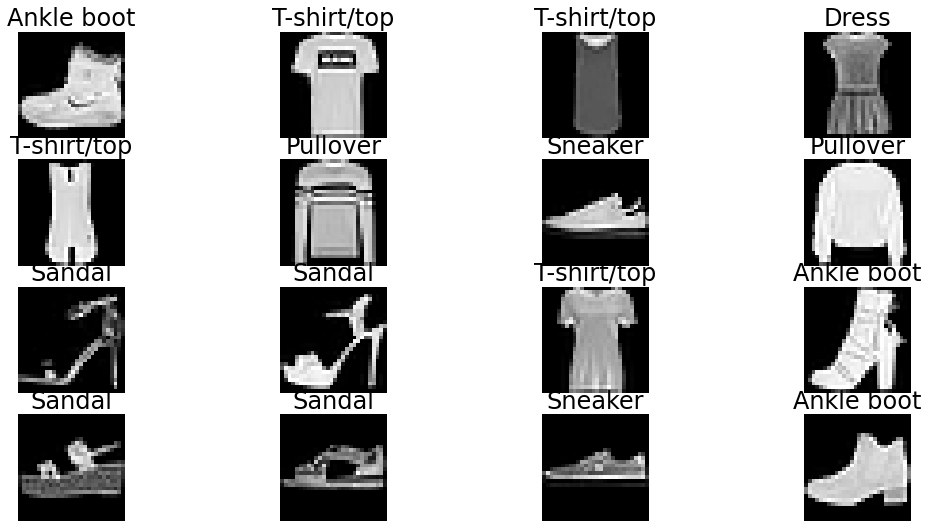

In [39]:
fig, axes = plt.subplots(4, 4)

for i, ax in enumerate(axes.flat):
    ax.imshow(x_trn[i], cmap='gray')
    ax.set_title(class_names[y_trn[i, 0]])
    ax.axis('off')

#### Обработка набора данных

In [40]:
x_trn = x_trn / 255.0
x_tst = x_tst / 255.0

print(x_trn.dtype)
print(x_tst.dtype)

float64
float64


![](https://miro.medium.com/max/2474/1*ggtP4a5YaRx6l09KQaYOnw.png)

In [41]:
y_trn = y_trn.astype(np.float32)
y_tst = y_tst.astype(np.float32)

y_trn = keras.utils.to_categorical(y_trn)
y_tst = keras.utils.to_categorical(y_tst)

print(y_trn.dtype)
print(y_tst.dtype)

float32
float32


Добавим разбиение на проверочные данные

In [42]:
from sklearn.model_selection import train_test_split

In [43]:
x_trn, x_vld, y_trn, y_vld = train_test_split(x_trn, y_trn, test_size=0.2, stratify=y_trn)

print(x_trn.shape, y_trn.shape)
print(x_vld.shape, y_vld.shape)

(48000, 28, 28) (48000, 10)
(12000, 28, 28) (12000, 10)


In [44]:
x_trn = x_trn[..., None]
x_vld = x_vld[..., None]
x_tst = x_tst[..., None]

print(x_trn.shape)
print(x_vld.shape)
print(x_tst.shape)

(48000, 28, 28, 1)
(12000, 28, 28, 1)
(10000, 28, 28, 1)


### Архитектура сети

In [45]:
from functools import partial

In [46]:
Conv2D = partial(layers.Conv2D, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu')

In [47]:
model = models.Sequential()

model.add(layers.InputLayer(input_shape=(28, 28, 1)))
model.add(Conv2D(filters=16))
model.add(layers.MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(filters=8))
model.add(layers.MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(filters=4))
model.add(layers.MaxPool2D(pool_size=(2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(units=32, activation='relu'))
model.add(layers.Dropout(rate=0.5))
model.add(layers.Dense(units=16, activation='relu'))
model.add(layers.Dropout(rate=0.5))
model.add(layers.Dense(units=10, activation='softmax'))

model.compile(
    optimizer='sgd',
    loss='categorical_crossentropy',
    metrics=[
        metrics.CategoricalAccuracy(name='accuracy'),
    ],
)

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 4)           292       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 4)           0         
_________________________________________________________________
flatten (Flatten)            (None, 36)               

In [48]:
history = model.fit(
    x=x_trn,
    y=y_trn,
    batch_size=32,
    epochs=16,
    validation_data=(x_vld, y_vld),
)

Epoch 1/16
1500/1500 [==============================] - 9s 6ms/step - loss: 2.2754 - accuracy: 0.1351 - val_loss: 2.1123 - val_accuracy: 0.2692
Epoch 2/16
1500/1500 [==============================] - 9s 6ms/step - loss: 1.8580 - accuracy: 0.3087 - val_loss: 1.2014 - val_accuracy: 0.6274
Epoch 3/16
1500/1500 [==============================] - 10s 7ms/step - loss: 1.4520 - accuracy: 0.4511 - val_loss: 0.9628 - val_accuracy: 0.6762
Epoch 4/16
1500/1500 [==============================] - 10s 7ms/step - loss: 1.2962 - accuracy: 0.4983 - val_loss: 0.8690 - val_accuracy: 0.6655
Epoch 5/16
1500/1500 [==============================] - 8s 6ms/step - loss: 1.2163 - accuracy: 0.5191 - val_loss: 0.8282 - val_accuracy: 0.6712
Epoch 6/16
1500/1500 [==============================] - 9s 6ms/step - loss: 1.1696 - accuracy: 0.5405 - val_loss: 0.8027 - val_accuracy: 0.7007
Epoch 7/16
1500/1500 [==============================] - 9s 6ms/step - loss: 1.1369 - accuracy: 0.5483 - val_loss: 0.7664 - val_accurac

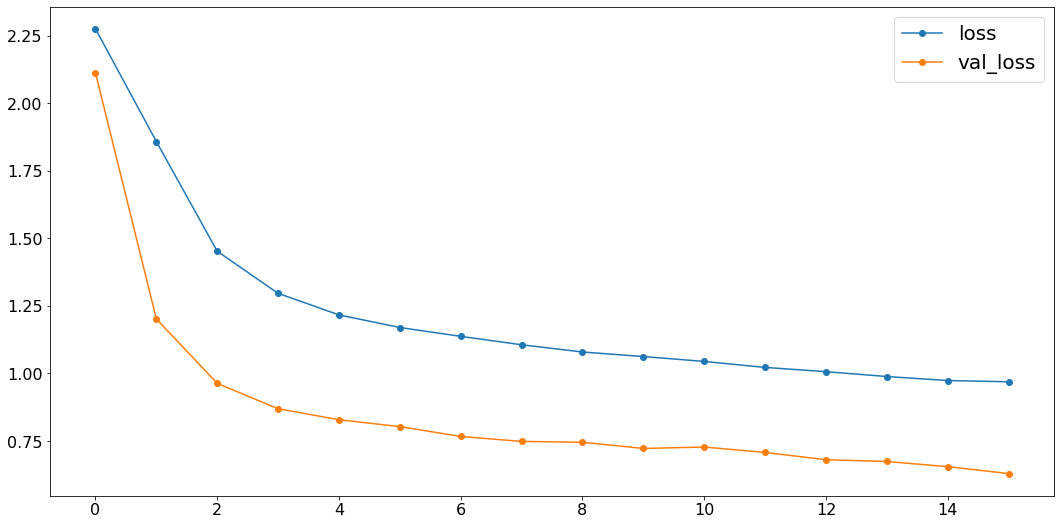

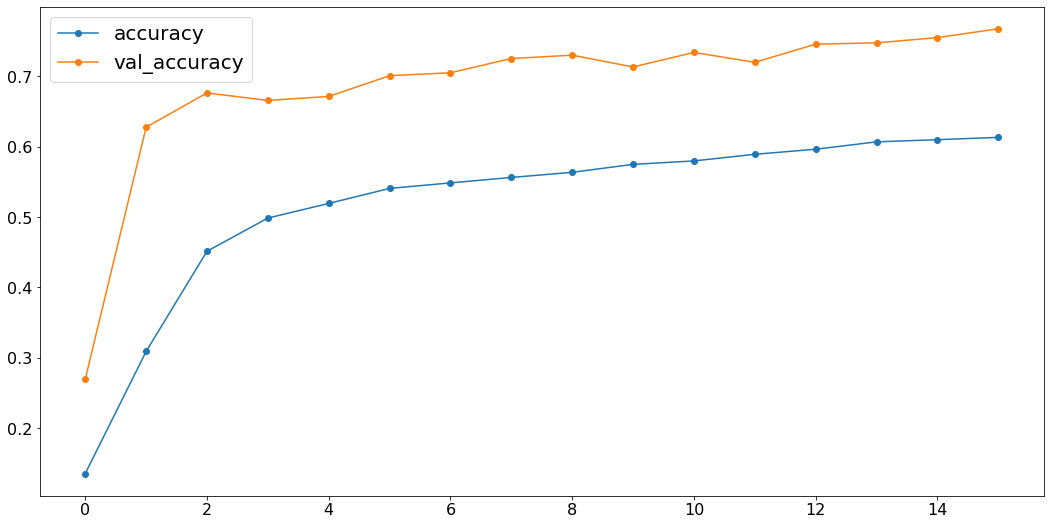

In [49]:
history_df = pd.DataFrame(history.history)

for metric in list(history.history.keys())[:2]:
    history_df[[metric, 'val_'+metric]].plot(style='-o', figsize=(18, 9), fontsize=16)

In [50]:
model.evaluate(x_tst, y_tst)

313/313 [==============================] - 1s 2ms/step - loss: 0.6394 - accuracy: 0.7646


[0.6393918395042419, 0.7645999789237976]

### Визуализация знаний, заключённых в сверточной нейронной сети

**в случае полносвязных НС, можно визуализировать веса**

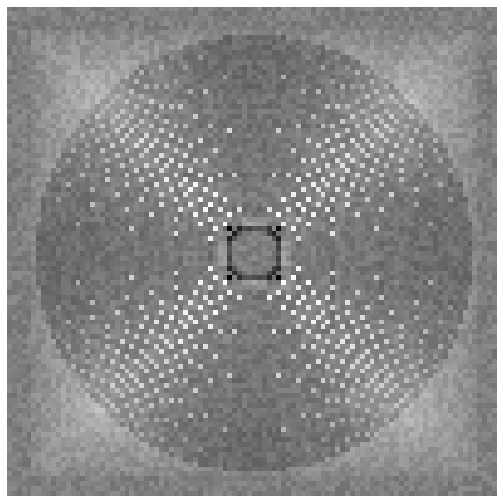

**визуализация карт признаков**

[2D Visualization of a Convolution Neural Network](https://www.cs.ryerson.ca/~aharley/vis/conv/flat.html)

**визуализация методом градиентного восхождения в пространстве входов**

[How convolutional neural networks see the world](https://blog.keras.io/how-convolutional-neural-networks-see-the-world.html)

![](https://blog.keras.io/img/vgg16_filters_overview.jpg)
![](https://4.bp.blogspot.com/-tTYZpdJ18bg/VYITAO4s_uI/AAAAAAAAAlE/L7VMImFFt_M/s640/noise-to-banana.png)

**DeepDream**

![](https://4.bp.blogspot.com/-FPDgxlc-WPU/VYIV1bK50HI/AAAAAAAAAlw/YIwOPjoulcs/s1600/skyarrow.png)
![](https://3.bp.blogspot.com/-R15_fyB-ZpE/VYIV-Uu9iwI/AAAAAAAAAl4/o3heQNGpVRU/s640/Funny-Animals.png)

**визуализация тепловых карт активации класса**

Shuttle | Dog
- | - 
![alt](https://www.pyimagesearch.com/wp-content/uploads/2020/03/keras_gradcam_space_shuttle.png) | ![alt](https://www.pyimagesearch.com/wp-content/uploads/2020/03/keras_gradcam_beagle.png)

### Adversarial attacks

![](https://hsto.org/getpro/habr/post_images/091/42d/a2b/09142da2b2212331a994cd5b6b006205.png)

![](https://miro.medium.com/max/4000/1*PmCgcjO3sr3CPPaCpy5Fgw.png)

![](https://www.cse.gatech.edu/sites/cse.gatech.edu/files/images/mercury/shapeshifterimg.png)

![](./../images/03-adversarial-attack-alexa.png)

In [51]:
from IPython.display import YouTubeVideo

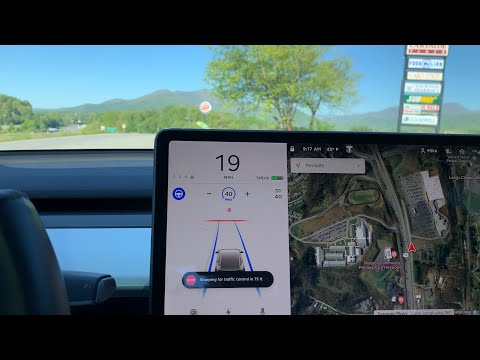

In [52]:
YouTubeVideo('jheBCOpE9ws')